# Assignment 3 - Kernel SVM
---
Muhammed Ersoy - mue@tamu.edu - [Github Repository](https://github.com/UlascanErsoy/ECEN427-TAMU)

- [Step 1 | Loading the data & Standardization](#step1)
- [Step 2 | The Kernel SVM Algorithm](#step2)
- [Step 3 | All-pair MultiClass Classifier](#step3)
- [Step 4 | One-vs-all Classifier](#step4)

---

### Step 0 - Environment

In [264]:
from typing import Optional, List, Iterator, Dict, Callable
from collections import defaultdict
from abc import ABC, abstractmethod
from pandas.api.types import is_float_dtype
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import itertools
import numpy as np
import pandas as pd
import seaborn

<h3 id="step1">Step 1 - Loading the Data & Standardization</h4>

<Axes: xlabel='Sepal Length', ylabel='Petal Length'>

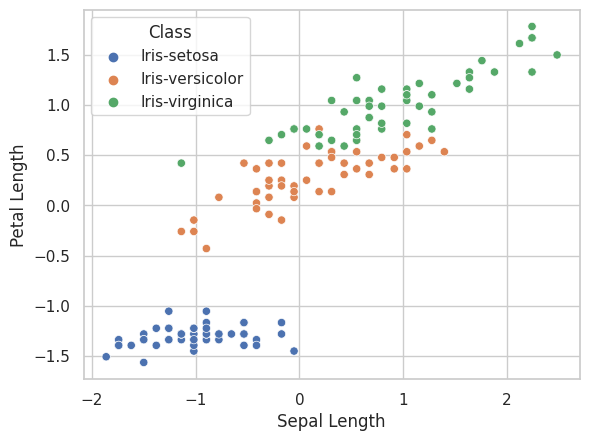

In [265]:
df = pd.read_csv(
            "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data",
            header=None,
            encoding="utf-8"
        )
df.columns = ['Sepal Length', 'Sepal Width', 'Petal Length','Petal Width','Class']

for col in df.columns:
    if is_float_dtype(df[col].dtype):
        mean = df[col].mean()
        std  = df[col].std()

        df[col] = df[col]\
                    .apply(lambda x: (x - mean) / std)
        
seaborn.set(style='whitegrid')
seaborn.scatterplot(x='Sepal Length',
                    y='Petal Length',
                    hue='Class',
                    data=df)

<h3 id="step2">Step 2 - The Kernel SVM Algorithm</h4>

In [318]:
class Trainable(ABC):
        
        @abstractmethod
        def train(self, X: np.ndarray, 
                        y: np.ndarray,
                        seed: Optional[int] = None
                    ):
            pass

        @abstractmethod
        def predict(self, X: np.ndarray) -> np.ndarray:
            pass 

class Kernels(ABC):
    
    @staticmethod
    def linear(a: np.ndarray, b: np.ndarray) -> np.ndarray:
          """Linear kernel implementation for KVM
          :param a: feature vector 
          :type a: np.ndarray
          :param b: feature vector
          :type b: np.ndarray
          :returns: feature embedded vector
          :rtype: np.ndarray
          """
          return np.dot(a,b)
    
    @staticmethod
    def polynomial(degree: int) -> Callable[[np.ndarray,np.ndarray], np.ndarray]:
         """Returns a polynomial kernel method of the given order
         :param degree: the degree of the polynomial
         :type a: int
         :returns: method
         :rtype: callable
         """
         return lambda a,b: (1 + np.dot(a,b))**degree
    
    @staticmethod
    def rbf(gamma: float) -> Callable[[np.ndarray,np.ndarray], np.ndarray]:
        """Returns an rbf kernel method with a given gamma
         :param degree: the degree of the polynomial
         :type a: int
         :returns: method
         :rtype: callable
        """
        return lambda a,b: np.exp(-gamma * np.sum(np.subtract(a,b)**2, axis=-1))
            
class KernelSVM(Trainable):

    def __init__(self, kernel: Callable[[np.ndarray,np.ndarray],np.ndarray],
                       reg: float = 0.01,
                       n: int = 1000,
                       eta: float = 0.1):
        """Initialize and Adaline algorithm
        :param weights: initial weights 
        :type weights: ndarray | Column vector with size features + 1
        :param n: number of training iterations
        :type n: int
        :param alpha: the learning rate
        :type alpha: float , 0 < a < 1
        """
        self.reg: float = reg
        self.n: int = n
        self.eta: float = eta
        self.kernel: Callable[[np.ndarray,np.ndarray],np.ndarray] = kernel
        self.alphas: Optional[np.ndarray] = None
        self.labels: Optional[np.ndarray] = None
        self.features: Optional[np.ndarray] = None 
        self.bias: Optional[float] = None
    
    def train(self, X: np.ndarray, 
                    y: np.ndarray):
        """Train the weights for Adaline algorithm
        :param X: ndarray of feature vectors, bias element will
        be added automatically
        :type X: ndarray
        :param y: ndarray of result vector
        :type y: ndarray
        :param seed: seed for random number generator
        :type seed: None or int
        """
        self.alphas = np.zeros(X.shape[0])
        self.labels = y.copy()
        self.features = X.copy()
        self.bias = 0.0

        for _ in range(self.n):
            
            temp = np.array([np.dot(self.alphas* y, self.kernel(X,X[idx])) + self.bias
                        for idx in range(X.shape[0])])

            deltas = np.where(y * temp <= 1, 1, 0)
                
            self.alphas = (1 - self.reg * self.eta) * self.alphas + (self.eta / X.shape[0]) * deltas
            self.bias += (self.eta / X.shape[0]) * np.dot(y, deltas)

        
    def predict(self, X: np.ndarray) -> np.ndarray:
        """Make predictions based on internal weights
        :param X: the input vector (either the full sample set, 
        or a single sample)
        :type X: np.ndarray
        :param hardpred: Hard Prediction or soft?
        :type hardpred: bool
        :returns: prediction vector
        :rtype: ndarray
        """
        k = [self.kernel(X,self.features[idx]) 
                for idx in range(self.features.shape[0])]
        
        return np.sign(np.dot(self.alphas * self.labels, k) + self.bias)
    
    def draw_decision_boundary(self,
                                X: np.ndarray,
                                r: float = 0.02,
                                fill: bool = True):
        """Draw the decision boundary
        requires matplotlib
        :param X: feature vector
        :type X: np.ndarray
        :param r: resolution of the grid
        :type r: float
        """
        #define the corner points for a rectangle that
        #encapsulates our (2d) feature plane
        x1_min , x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        x2_min , x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1

        #generate points on this plane 
        #that splits the plane into a grid
        xx1, xx2 = np.meshgrid(
            np.arange(x1_min, x1_max, r),
            np.arange(x2_min, x2_max, r)
        )

        #generate predictions for everypoint in this grid
        #using the trained model
        pred = self.predict(
            np.array([xx1.ravel(), xx2.ravel()]).T
        )

        pred = pred.reshape(xx1.shape)
        
        colors = ['blue','red']
        if pred[0][0] == max(pred[0]):
            colors = colors[::-1]
            
        cmap = ListedColormap(colors)
        if fill:
            plt.contourf(xx1, xx2, pred, alpha=0.3, cmap=cmap)
        else:
            plt.contour(xx1, xx2, pred, alpha=0.3, cmap=cmap)

In [319]:
def prepare_data(df: pd.DataFrame, 
                 features: List[str],
                 class_row: str = "Class") -> (np.ndarray, np.ndarray):
    """Prepare the dataframe into input and target arrays
    :param df: pandas dataframe containing feature and target vectors
    :type df: DataFrame
    :param features: row names of features as a list
    :type features: List of strings
    :param class_row: Row name of target vector
    :type class_row: str (default = "Class")
    :returns: X , y
    :rtype: np.ndarray , np.ndarray
    """
    id_map = {name: idx
                for idx, name in enumerate(set(df[class_row]))
                }
    
    y = df[class_row]\
            .apply(lambda x: -1 if id_map[x] == 0 else 1)\
            .to_numpy()
    
    X = df[features].to_numpy()

    return X , y

Success Rate: 96.67%


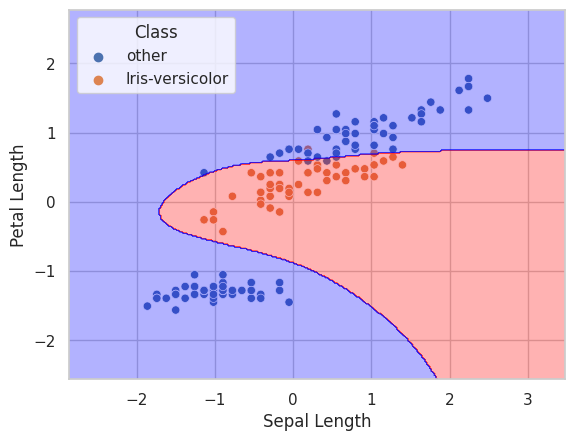

In [326]:
#use the model
features = ['Sepal Length','Petal Length']
df['Class'] = df['Class'].apply(lambda x: "other" if x != "Iris-versicolor" else "Iris-versicolor")
clean_df = df[df['Class'].isin(['Iris-versicolor','Iris-virginica','other'])]
X , y = prepare_data(clean_df, features)
model = KernelSVM(
    Kernels.polynomial(5),
    n=100,
    reg=0.01
)
model.train(X.copy(),y)

splt = seaborn.scatterplot(x='Sepal Length',
                    y='Petal Length',
                    hue='Class',
                    data=clean_df)

model.draw_decision_boundary(X)
predict = model.predict(X)
error_rate = 100 * (len(y) - np.equal(predict,y).sum())/len(y)
print(f"Success Rate: {100 - error_rate:.2f}%")